# Finding optimal parameters

In [271]:
!pip3 install bayesian-optimization
!pip install scipy==1.7

# Grid world class 

In [298]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 31 10:24:20 2022

@author: priya
"""

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import time 
import pandas as pd 
import seaborn as sns
import random
sns.set()

"""
Obstacles 
"""
BIDIRECTIONAL_WALLS = [(4,5), (18,24), (17,23), (30,31)] 
ONE_WAY_WALLS = [(7,1), (6, 12) ]
ONE_WAY_TUNNELS = [(6,30), (7,5)]

"""
Reward Structure
"""
DEFAULT_REWARD = -1 
REWARD = 25 #50
REWARD_LOC = [5, 13, 16, 32]
PENALTY = -100
PENALTY_LOC = [8, 17, 26, 30, 34] 
DST_REWARD = 1000
START = 0 
DST = 35


class grid_world():
    
    def __init__(self, logger):
        self.debug_mode = logger
        self.S = list(range(0,36))
        self.A = list(range(0,36))
        #self.walls =  [(4,5),  (18,24), (17,23), (30,31)] #[(3,4), (3,9), (4,5), (11,17), (17,23), (12,18), (18,24), (30,31), (27,33)]
        self.legal_moves = self.get_legal_moves()
        self.R = self.initialize_rewards()
        self.Q = np.zeros(self.R.shape)
        print("Grid world initialized!")
        
        
        
    def get_legal_moves(self):
        possible_actions = []
        illegal_moves = [] 

        #all adjacent locations for each cell 
        for row in range(0,6):
            for col in range(0, 6):
                current = row * 6 + col
        
                if col > 0:
                    left = current - 1
                    possible_actions.append((current, left))
                if col < 5:
                    right = current + 1
                    possible_actions.append((current, right))
                if row > 0:
                    up = current - 6
                    possible_actions.append((current, up))
                if row < 5:
                    down = current + 6
                    possible_actions.append((current, down))
                    
        #add tunnels 
        for tunnel in ONE_WAY_TUNNELS:
            possible_actions.append((tunnel[0], tunnel[1]))
        
        if self.debug_mode: print("# moves:", len(possible_actions))
        
        #add walls 
        for wall in BIDIRECTIONAL_WALLS:
            illegal_moves.append((wall[0], wall[1]))
            illegal_moves.append((wall[1], wall[0]))
            
        for wall in ONE_WAY_WALLS:
            illegal_moves.append((wall[0], wall[1]))
                    
    
        if self.debug_mode: print("# illegal moves:", len(illegal_moves))   

        for illegal_move in illegal_moves:
            possible_actions.remove(illegal_move)

        if self.debug_mode: 
            print("# legal moves:", len(possible_actions))
            print(possible_actions)
        
        return possible_actions


    def initialize_rewards(self):
        R = np.empty((len(self.A), len(self.S)))
        R[:] = np.nan
        
        for action in self.legal_moves:    
            if action[1] in REWARD_LOC: # Rewards
                R[action[0], action[1]] = REWARD
            elif action[1] in PENALTY_LOC: # Penalties
                R[action[0], action[1]] = PENALTY 
            elif action[1] == DST:  #destination
                R[action[0], action[1]] = DST_REWARD
            else:
                R[action[0], action[1]] = DEFAULT_REWARD
                
        return R
    
    
    def reset_Q(self):
        self.Q = np.zeros(self.R.shape)
        return 1
        
    
    
    """
    Epsilon-Greedy Policy 
    low epsilon - higher chance of exploitation 
    high epsilon - higher chance of exploration 
    """
    def decay_eps_greedy(self, eps, all_actions, best_actions): 
        if np.random.uniform() > eps:
            #exploit
            a = np.random.choice(best_actions)
        else:
            #explore
            a = np.random.choice(all_actions )
            
        return a
    
    
    """
    Softmax Policy 
    """
    def softmax(self, current_state, actions, T):
        if self.debug_mode:
            for action in actions:
                print(f'Q[{current_state},{action}] = {self.Q[current_state,action]}')

        probabilities = np.array([self.Q[current_state, a]/T for a in actions])
        if self.debug_mode: print(f'probabilities = {probabilities}')
    
        softmax_probabilities = np.exp(probabilities)/ np.sum(np.exp(probabilities))
        if self.debug_mode: print(f'softmax_probabilities= {softmax_probabilities}')
    
        # choose an action based on these probabilities
        a = random.choices(actions, weights=softmax_probabilities)
        
        return a[0]
    
    
    
        
        

    """
    Q-learning algo 
    """
    def run_q_learning(self, num_episodes, steps, alpha, gamma, policy, policy_args = {}):
        print(policy)
        time_start = time.time()
        
        #reset Q 
        self.reset_Q()
        #self.Q = np.zeros(self.R.shape)
        
        rewards_per_episode = []
        steps_per_episode = []
        found_flag = 0 
        
        path = []
        final_rewards = [] 
        

            
      
        if policy == 'eps_greedy' or policy == 'eps_greedy_decay' :
            decay_factor = policy_args.pop('decay_rate')   
            eps = [] 
            eps_start = 0.9
            eps.append(eps_start)
            for i in range(1, num_episodes):
                eps.append(eps[i-1]*decay_factor)
        else:
            tau = policy_args.pop('tau') 

    

    
        for i in range(num_episodes):    
            # Initialize State
            s = 0 #np.random.choice(36) #DO NOT RANDOMIZE INITIAL STATE: CANNOT ANALYZE AVG. STEPS-REWARDS/EPISODE 
            
            total_reward = 0
    
            if i%100 == 0 and self.debug_mode:
                print('Running episode {} ....'.format(i))
                    
            for step in range(steps):
                available_actions = np.where(~np.isnan(self.R[s]))[0]
                q_values = [self.Q[s,a] for a in available_actions]
                
                if policy == 'eps_greedy' or policy == 'eps_greedy_decay': 
                    best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
                    if self.debug_mode: print(f"Currently at {s}. best actions: {best_actions}. Step: {step}")
                
                    #best_actions_q_values = [Q[s,x] for x in best_actions]
                    
                    a = self.decay_eps_greedy(eps[i], available_actions, best_actions)
                    if self.debug_mode : print(f"choose: {a}")

                elif policy == 'softmax':
                    a = self.softmax(s, available_actions, tau) #tau[i])
                    if self.debug_mode: print(f"Currently at {s}. action selected: {a}. Step: {step}")

                
                r = self.R[s,a]
                
                
                if i == (num_episodes-1):
                    path.append(a)
                
                if a in REWARD_LOC or a == DST  : # Reward/Flag found
                    if self.debug_mode : print(f"Found reward. Adding {max((r - step),0) }")
                    total_reward += max((r - step),0)  # Discount reward based on steps
                    if i == (num_episodes-1):
                        final_rewards.append(max((r - step),0))
                else: #penalty or normal step 
                    total_reward += r
                    if i == (num_episodes-1):
                        final_rewards.append(r)      
                
                if self.debug_mode: print(f"new reward total: {total_reward}")
                s_old = s
                s = a 
    
                # Q value updating
                q_updated = self.Q[s_old,a] + alpha * ( r + gamma * np.max(self.Q[s,:]) - self.Q[s_old,a])
                
                if self.Q[s_old,a] != q_updated and self.debug_mode:
                    print(f"Old q value:  { self.Q[s_old,a]}, new Q value: {q_updated}")
                    
                self.Q[s_old,a] = q_updated

                #for softmax, normalize Q before next iteration to avoid overflow 
                #if policy == 'softmax':
                #  self.Q = self.Q/np.max(np.abs(self.Q)) #initially when rewards are negtive ,causes divide by 0, use abs 
    
                if self.S[s] == DST: # Destination Reached
                    rewards_per_episode.append(total_reward)
                    steps_per_episode.append(step)
                    found_flag += 1 
                    break
                elif step == (steps -1): #out of steps
                    rewards_per_episode.append(total_reward)
                    steps_per_episode.append(step)
    
        print(f"time elapsed for {num_episodes} episodes : {time.time()-time_start} s")
        print("Path: ", path)
        print("Rewards: ", final_rewards)
        print(f"Total rewards: {sum(final_rewards)} , Total path length: {len(path)}" )
            
        return rewards_per_episode, steps_per_episode, found_flag, self.Q
    
    
    def plot_graph(self, df, title, x_label, y_label, legend_title = None):
        sns.set(rc = {'figure.figsize':(15,5)})
        sns.set_style("whitegrid", {'axes.grid' : False})

        dashes_val = ['' for x in df.columns]

        f = sns.lineplot(data=df, dashes = dashes_val)

        f.set_xlabel(x_label, fontsize = 15)
        f.set_ylabel(y_label, fontsize = 15)
        f.set_title(title)

        if legend_title: 
          leg = f.axes.get_legend()
          leg.set_title(legend_title)
              
                                  
                        

In [273]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import time 
import pandas as pd 
import seaborn as sns
import random
sns.set()
import importlib
#import grid_world

In [274]:
myGridWorld = grid_world(False)

Grid world initialized!


In [275]:
NUM_EPISODES = 600 
MAX_STEPS = 500 

# Epsilon-Decay

## Plot epsilon decay rates explored

In [ ]:
eps_decay_rate =  np.array([0.995, 0.998, 0.999, 0.9995, 0.9999]) #np.array([0.9, 0.99, 0.995, 0.999, 0.9999]) #np.arange(0.99, 0.999, 0.001)
#num_episodes = NUM_EPISODES 
eps_start = 0.9

df = pd.DataFrame()

for eps in eps_decay_rate:   
  eps_exp = [] 
  eps_exp.append(eps_start)
  for i in range(1, NUM_EPISODES):
      eps_exp.append(eps_exp[i-1]*eps)
  col_name = str(eps)
  df[col_name] = eps_exp




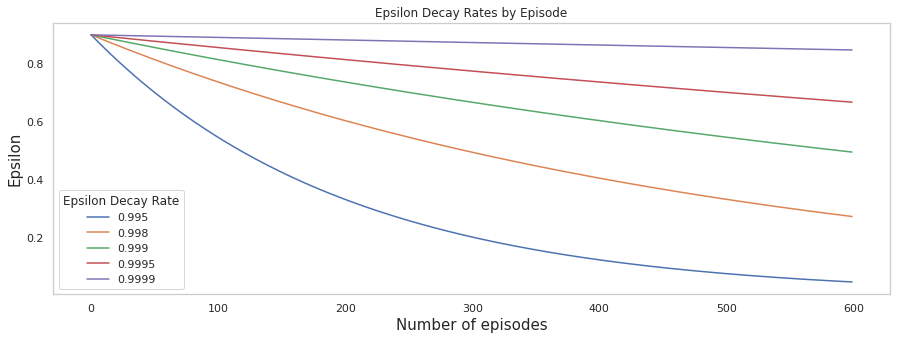

In [ ]:
myGridWorld.plot_graph(df, "Epsilon Decay Rates by Episode", "Number of episodes", "Epsilon", "Epsilon Decay Rate")

In [ ]:
df.tail()

,0.995,0.998,0.999,0.9995,0.9999
595,0.045601,0.273473,0.496259,0.668356,0.848009
596,0.045373,0.272926,0.495762,0.668021,0.847925
597,0.045146,0.272380,0.495267,0.667687,0.847840
598,0.044921,0.271836,0.494771,0.667354,0.847755
599,0.044696,0.271292,0.494276,0.667020,0.847670


## Find optimal epsilon decay rate

In [ ]:
eps_decay_rate = np.array([0.995, 0.998, 0.999, 0.9995, 0.9999]) 

alpha = 0.5
policy = "eps_greedy_decay"
gamma = 0.5
max_steps = MAX_STEPS

num_eps = NUM_EPISODES 
df_rewards = pd.DataFrame(columns = eps_decay_rate)
df_steps = pd.DataFrame(columns = eps_decay_rate)
df_ts = pd.DataFrame(columns = eps_decay_rate)

num_iter = 3

for eps in eps_decay_rate: 
    print("eps: ", eps)

    total_rewards = [0] * num_eps
    total_steps = [0] * num_eps 
    total_found_flag = 0

    #run each parameter for 3 iterations 
    for i in range(num_iter):
      rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,  {'decay_rate': eps})
      total_rewards = [sum(x) for x in zip(rewards_per_episode, total_rewards)] 
      total_steps = [sum(x) for x in zip(steps_per_episode, total_steps)]
      total_found_flag += found_flag
      

    #save average across iterations                                                              
    df_rewards[eps] = [x/num_iter for x in total_rewards ] #rewards_per_episode 
    df_steps[eps] = [x/num_iter for x in total_steps] #steps_per_episode
    df_ts[eps] = [total_found_flag/num_iter]



eps:  0.995
eps_greedy_decay
time elapsed for 600 episodes : 0.7711145877838135 s
Path:  [6, 7, 5, 11, 10, 16, 22, 23, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
eps_greedy_decay
time elapsed for 600 episodes : 0.8389935493469238 s
Path:  [6, 7, 5, 11, 10, 16, 22, 28, 29, 28, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, -1.0, -1.0, 989.0]
eps_greedy_decay
time elapsed for 600 episodes : 0.9488227367401123 s
Path:  [1, 7, 5, 11, 10, 16, 22, 28, 27, 28, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, -1.0, -1.0, 989.0]
eps:  0.998
eps_greedy_decay
time elapsed for 600 episodes : 1.8177881240844727 s
Path:  [6, 7, 8, 7, 8, 9, 3, 4, 10, 16, 22, 28, 29, 28, 34, 35]
Rewards:  [-1.0, -1.0, -100.0, -1.0, -100.0, -1.0, -1.0, -1.0, -1.0, 16.0, -1.0, -1.0, -1.0, -1.0, -100.0, 985.0]
eps_greedy_decay
time elapsed for 600 episodes : 1.3556392192840576 s
Path:  [1, 7, 13, 14, 15, 16, 15, 16, 17, 16, 22, 28, 29,

In [ ]:
#get rolling average to smooth curve 
for col in df_rewards.columns: 
  df_rewards[col] = df_rewards[col].rolling(window=20).mean()

for col in df_steps.columns: 
  df_steps[col] = df_steps[col].rolling(window=20).mean()

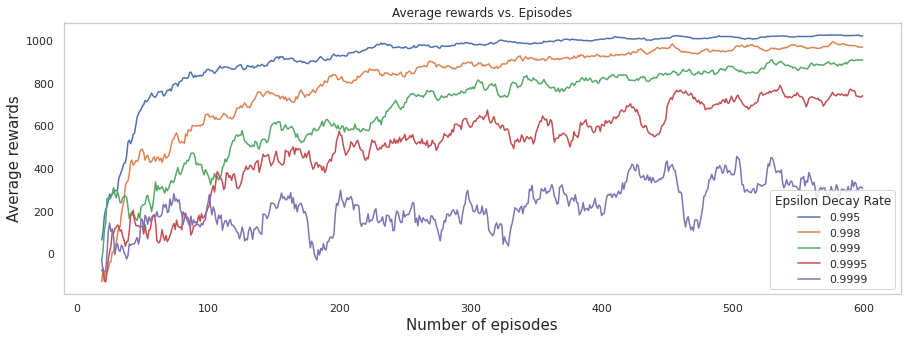

In [ ]:
myGridWorld.plot_graph(df_rewards.iloc[:, :], "Average rewards vs. Episodes", "Number of episodes", "Average rewards", "Epsilon Decay Rate")

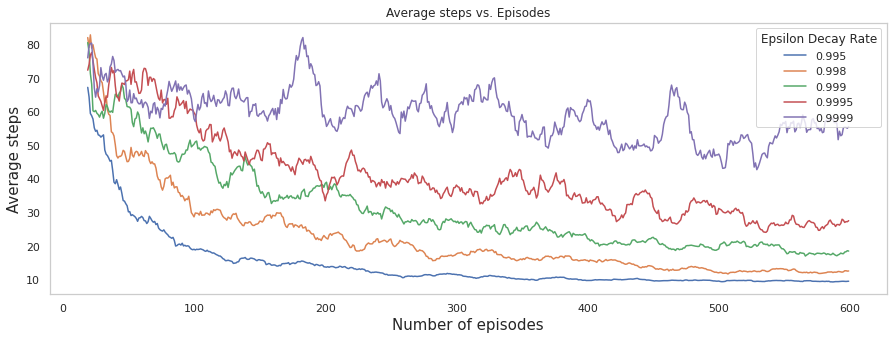

In [ ]:
myGridWorld.plot_graph(df_steps.iloc[:, :], "Average steps vs. Episodes", "Number of episodes", "Average steps", "Epsilon Decay Rate")

In [ ]:
df_ts

,0.9950,0.9970,0.9980,0.9990,0.9995,0.9999
0,600.0,600.0,600.0,600.0,600.0,600.0


## Explore alpha with eps-greedy 

In [ ]:
#alphas = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
alphas = np.array([0, 0.3, 0.5, 0.7, 0.9, 1])

policy = "eps_greedy_decay"
eps_decay_rate = 0.995
gamma = 0.5 
max_steps = MAX_STEPS
num_eps = NUM_EPISODES 

df_rewards = pd.DataFrame(columns = alphas)
df_steps = pd.DataFrame(columns = alphas)
df_ts = pd.DataFrame(columns = alphas)


num_iter = 3

for alpha in alphas: 
    print("alpha: ", alpha)

    total_rewards = [0] * num_eps
    total_steps = [0] * num_eps 
    total_found_flag = 0

    #run each parameter for 3 iterations 
    for i in range(num_iter):
      rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,
                                                                                         {'decay_rate': eps_decay_rate}
                                                                                         )
      total_rewards = [sum(x) for x in zip(rewards_per_episode, total_rewards)] 
      total_steps = [sum(x) for x in zip(steps_per_episode, total_steps)]
      total_found_flag += found_flag
      

    #save average across iterations                                                              
    df_rewards[alpha] = [x/num_iter for x in total_rewards ] #rewards_per_episode 
    df_steps[alpha] = [x/num_iter for x in total_steps] #steps_per_episode
    df_ts[alpha] = [total_found_flag/num_iter]


alpha:  0.0
eps_greedy_decay
time elapsed for 600 episodes : 5.28535008430481 s
Path:  [1, 0, 6, 0, 6, 7, 6, 0, 6, 30, 24, 30, 24, 25, 31, 25, 26, 32, 26, 25, 26, 20, 21, 22, 23, 22, 23, 22, 16, 15, 14, 8, 9, 8, 9, 10, 9, 3, 4, 10, 11, 5, 11, 10, 9, 3, 4, 3, 9, 15, 16, 17, 11, 17, 11, 10, 11, 17, 16, 10, 16, 17, 11, 17, 11, 17, 16, 22, 28, 29, 35]
Rewards:  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -100.0, -1.0, -100.0, -1.0, -1.0, -1.0, -1.0, -100.0, 8.0, -100.0, -1.0, -100.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0, -1.0, -1.0, -100.0, -1.0, -100.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0, -100.0, -1.0, -100.0, -1.0, -1.0, -1.0, -100.0, 0, -1.0, 0, -100.0, -1.0, -100.0, -1.0, -100.0, 0, -1.0, -1.0, -1.0, 930.0]
eps_greedy_decay
time elapsed for 600 episodes : 5.084539175033569 s
Path:  [6, 0, 6, 7, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 10, 4, 10, 4, 10, 9, 8, 7, 6, 7, 13, 19, 20, 26, 25, 24, 30, 24, 30, 24, 2

In [ ]:
#get rolling average to smooth curve 
for col in df_rewards.columns: 
  df_rewards[col] = df_rewards[col].rolling(window=20).mean()

for col in df_steps.columns: 
  df_steps[col] = df_steps[col].rolling(window=20).mean()

In [ ]:
df_rewards.iloc[:100, :].describe()

,0.0,0.3,0.5,0.7,0.9,1.0
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,-835.110082,610.512551,655.163169,674.009671,681.643827,660.824074
std,236.972041,222.470434,176.711262,192.324425,204.578428,184.999011
min,-1343.783333,-96.566667,120.216667,40.116667,-38.333333,59.250000
25%,-936.400000,508.466667,537.800000,589.516667,659.750000,586.550000
50%,-774.750000,710.516667,698.783333,731.133333,760.100000,708.150000
75%,-638.316667,770.933333,789.300000,810.316667,802.100000,788.433333
max,-513.750000,829.033333,877.966667,869.316667,851.066667,879.683333


In [ ]:
df_steps.describe()

,0.0,0.3,0.5,0.7,0.9,1.0
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,121.982272,15.223810,14.430149,14.379145,14.542054,14.761618
std,12.740792,10.605823,8.184146,8.589237,8.879095,8.806260
min,92.233333,9.366667,9.400000,9.250000,9.350000,9.250000
25%,112.800000,9.700000,9.766667,9.833333,9.816667,9.900000
50%,121.966667,10.816667,11.216667,10.900000,11.066667,11.000000
75%,131.350000,15.066667,15.633333,14.350000,15.833333,15.933333
max,155.166667,80.966667,66.166667,72.366667,78.650000,71.983333


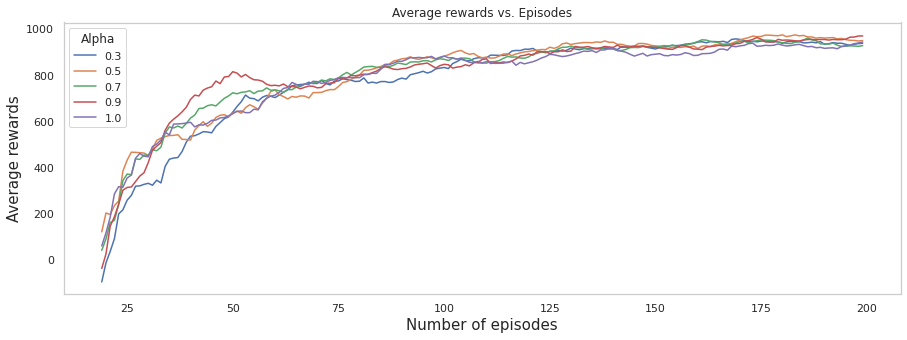

In [ ]:
myGridWorld.plot_graph(df_rewards.iloc[:200, 1:], "Average rewards vs. Episodes", "Number of episodes", "Average rewards", "Alpha")

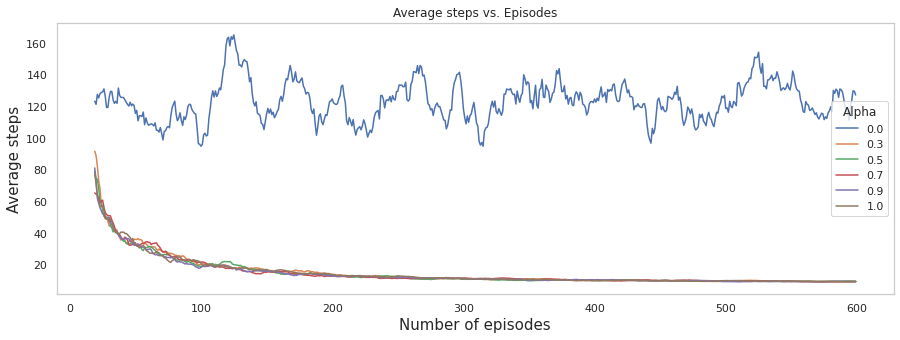

In [ ]:
myGridWorld.plot_graph(df_steps.iloc[:, :], "Average steps vs. Episodes", "Number of episodes", "Average steps", "Alpha")

In [ ]:
df_ts

,0.0,0.3,0.5,0.7,0.9,1.0
0,318.666667,593.333333,595.333333,591.333333,597.0,591.666667


## Explore gamma with eps-greedy 

In [ ]:
#alphas = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
gammas = np.array([0, 0.3, 0.5, 0.7, 0.9, 1])

policy = "eps_greedy_decay"
eps_decay_rate = 0.995
alpha = 0.5 
max_steps = MAX_STEPS
num_eps = NUM_EPISODES 

df_rewards = pd.DataFrame(columns = gammas)
df_steps = pd.DataFrame(columns = gammas)
df_ts = pd.DataFrame(columns = gammas)


num_iter = 3

for gamma in gammas: 
    print("gamma: ", gamma)

    total_rewards = [0] * num_eps
    total_steps = [0] * num_eps 
    total_found_flag = 0

    #run each parameter for 3 iterations 
    for i in range(num_iter):
      rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,
                                                                                         {'decay_rate': eps_decay_rate}
                                                                                         )
      total_rewards = [sum(x) for x in zip(rewards_per_episode, total_rewards)] 
      total_steps = [sum(x) for x in zip(steps_per_episode, total_steps)]
      total_found_flag += found_flag
      

    #save average across iterations                                                              
    df_rewards[gamma] = [x/num_iter for x in total_rewards ] #rewards_per_episode 
    df_steps[gamma] = [x/num_iter for x in total_steps] #steps_per_episode
    df_ts[gamma] = [total_found_flag/num_iter]


gamma:  0.0
eps_greedy_decay
time elapsed for 600 episodes : 14.318831205368042 s
Path:  [1, 2, 3, 4, 10, 16, 22, 16, 15, 16, 15, 16, 15, 16, 15, 16, 10, 16, 15, 16, 22, 16, 10, 16, 15, 16, 10, 16, 15, 16, 10, 16, 10, 16, 15, 16, 15, 16, 22, 16, 15, 16, 22, 16, 10, 16, 10, 16, 10, 16, 22, 16, 10, 16, 22, 16, 15, 16, 15, 16, 15, 16, 22, 16, 22, 16, 10, 16, 15, 16, 15, 16, 15, 16, 22, 16, 15, 16, 15, 16, 15, 16, 15, 16, 10, 16, 15, 16, 22, 16, 22, 16, 22, 16, 15, 16, 10, 16, 15, 16, 22, 16, 22, 16, 10, 16, 10, 16, 22, 16, 22, 16, 15, 16, 10, 16, 15, 16, 10, 16, 15, 16, 22, 16, 15, 16, 22, 16, 10, 16, 22, 16, 15, 16, 22, 16, 15, 16, 15, 16, 22, 16, 10, 16, 15, 16, 10, 16, 15, 16, 10, 16, 15, 16, 10, 16, 10, 16, 10, 16, 15, 16, 15, 16, 22, 16, 15, 16, 15, 16, 17, 16, 22, 16, 22, 16, 22, 16, 10, 16, 15, 16, 10, 16, 10, 16, 10, 16, 15, 16, 15, 16, 10, 16, 22, 16, 15, 16, 15, 16, 15, 16, 10, 16, 10, 16, 10, 16, 10, 16, 10, 16, 15, 16, 15, 16, 15, 16, 10, 16, 22, 16, 22, 16, 22, 16, 22, 16, 22

In [ ]:
#get rolling average to smooth curve 
for col in df_rewards.columns: 
  df_rewards[col] = df_rewards[col].rolling(window=20).mean()

for col in df_steps.columns: 
  df_steps[col] = df_steps[col].rolling(window=20).mean()

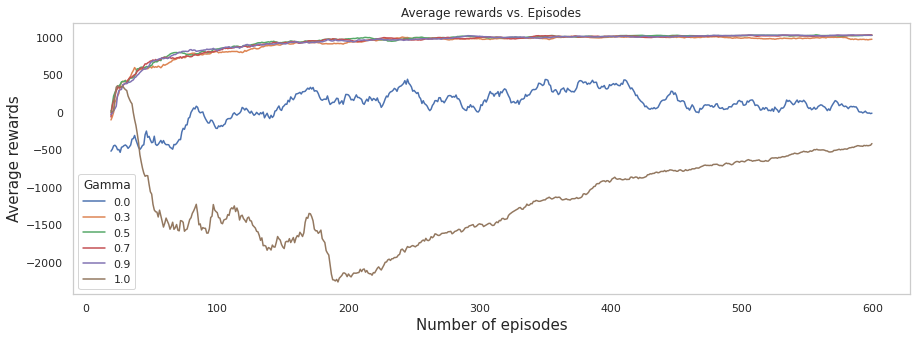

In [ ]:
myGridWorld.plot_graph(df_rewards.iloc[:, :], "Average rewards vs. Episodes", "Number of episodes", "Average rewards", "Gamma")

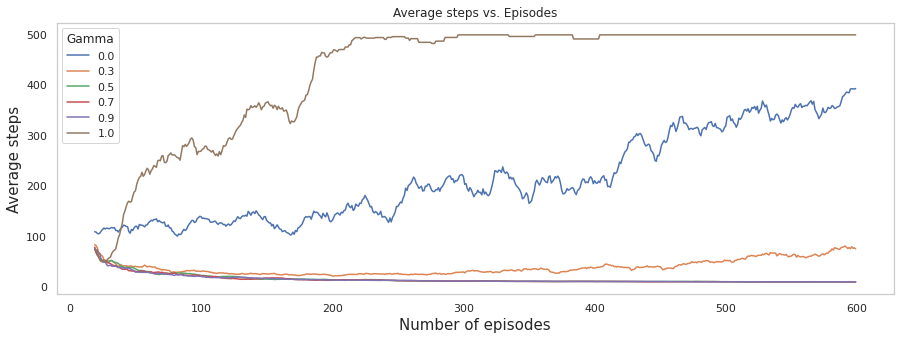

In [ ]:
myGridWorld.plot_graph(df_steps.iloc[:, :], "Average steps vs. Episodes", "Number of episodes", "Average steps", "Gamma")

In [ ]:
df_ts

,0.0,0.3,0.5,0.7,0.9,1.0
0,511.0,600.0,599.666667,600.0,600.0,138.333333


# Boltzmann (softmax Policy)

## Plot rates of decay for tau

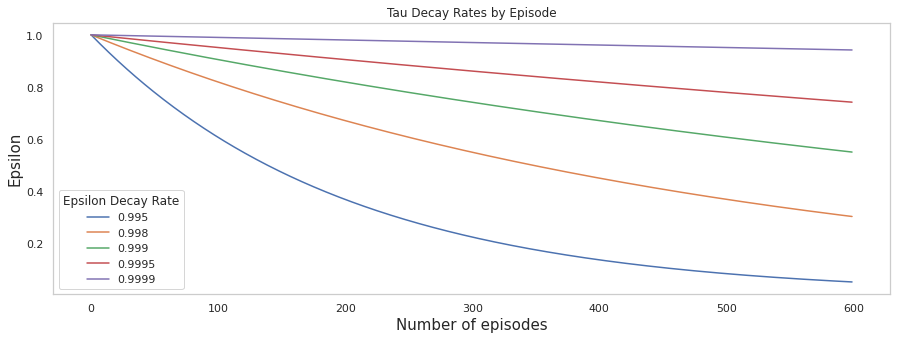

In [ ]:
tau_decay_rate = np.array([0.995, 0.998, 0.999, 0.9995, 0.9999]) #np.array([0.9, 0.99, 0.995, 0.999, 0.9999]) #np.arange(0.99, 0.999, 0.001)
#num_episodes = NUM_EPISODES 
tau_start = 1 #0.9

df = pd.DataFrame()

for tau in tau_decay_rate:   
  tau_exp = [] 
  tau_exp.append(tau_start)
  for i in range(1, NUM_EPISODES):
      tau_exp.append(tau_exp[i-1]*tau)
  col_name = str(tau)
  df[col_name] = tau_exp


myGridWorld.plot_graph(df, "Tau Decay Rates by Episode", "Number of episodes", "Epsilon", "Epsilon Decay Rate")


In [ ]:
df.tail

,0.995,0.998,0.999,0.9995,0.9999
595,0.050668,0.303859,0.551398,0.742617,0.942233
596,0.050415,0.303251,0.550847,0.742246,0.942139
597,0.050163,0.302645,0.550296,0.741875,0.942044
598,0.049912,0.302039,0.549746,0.741504,0.941950
599,0.049662,0.301435,0.549196,0.741133,0.941856


In [ ]:
np.linspace(6, 14, 9, endpoint = True, dtype = int )

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])

## Find optimal Tau

In [ ]:
myGridWorld = grid_world(False)
taus = np.array([6,7,8,9,10,])
    np.linspace(6, 15, 10, endpoint = True, dtype = int )
#np.linspace(5, 15, 11, endpoint = True, dtype = int )
#np.linespace(5, 15, 1) #[5, 8, 10, 15]# [1000] #np.array([0.5]) #np.array([1, 0.7, 0.5, 0.3])#np.array([0.995, 0.999, 0.9999, 0.99999]) 

# np.array([0.995, 0.998, 0.999, 0.9995, 0.9999]) 

alpha = 0.5
policy = "softmax"
gamma = 0.5
max_steps = MAX_STEPS

num_eps = NUM_EPISODES
df_rewards = pd.DataFrame(columns = taus)
df_steps = pd.DataFrame(columns = taus)
df_ts = pd.DataFrame(columns = taus)

num_iter = 3

for tau in taus: 
    print("tau: ", tau)

    total_rewards = [0] * num_eps
    total_steps = [0] * num_eps 
    total_found_flag = 0

    #run each parameter for 3 iterations 
    for i in range(num_iter):
      rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,  {'tau': tau})
      total_rewards = [sum(x) for x in zip(rewards_per_episode, total_rewards)] 
      total_steps = [sum(x) for x in zip(steps_per_episode, total_steps)]
      total_found_flag += found_flag
      

    #save average across iterations                                                              
    df_rewards[tau] = [x/num_iter for x in total_rewards ] #rewards_per_episode 
    df_steps[tau] = [x/num_iter for x in total_steps] #steps_per_episode
    df_ts[tau] = [total_found_flag/num_iter]



Grid world initialized!
tau:  6
softmax
time elapsed for 600 episodes : 0.954214334487915 s
Path:  [6, 7, 5, 11, 10, 16, 22, 28, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
softmax
time elapsed for 600 episodes : 1.3640944957733154 s
Path:  [6, 7, 5, 11, 10, 16, 22, 23, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
softmax
time elapsed for 600 episodes : 1.061779499053955 s
Path:  [1, 7, 5, 11, 10, 16, 22, 28, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
tau:  7
softmax
time elapsed for 600 episodes : 0.670799732208252 s
Path:  [6, 7, 5, 11, 10, 16, 22, 28, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
softmax
time elapsed for 600 episodes : 1.502953290939331 s
Path:  [1, 0, 1, 7, 13, 14, 15, 16, 22, 23, 29, 35]
Rewards:  [-1.0, -1.0, -1.0, -1.0, 21.0, -1.0, -1.0, 18.0, -1.0, -1.0, -1.0, 989.0]
softmax
time elapsed for 600 episodes : 0.6309878826141

In [ ]:
#get rolling average to smooth curve 
for col in df_rewards.columns: 
  df_rewards[col] = df_rewards[col].rolling(window=5).mean()

for col in df_steps.columns: 
  df_steps[col] = df_steps[col].rolling(window=5).mean()

In [ ]:
df_rewards.iloc[5:50, :-1].describe()

,6,7,8,9,10,11,12,13,14
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,690.709630,558.271111,739.336296,856.568889,989.069630,949.671111,1021.254815,990.247407,1025.200000
std,363.550601,264.066875,340.190895,237.548598,67.454670,164.896294,43.325259,42.310955,19.402697
min,135.933333,-106.800000,-161.933333,87.133333,633.666667,295.066667,764.600000,765.666667,949.266667
25%,308.266667,635.000000,660.400000,629.733333,1000.800000,998.200000,1024.733333,991.666667,1019.000000
50%,872.000000,648.533333,728.933333,1005.200000,1006.266667,1007.866667,1031.200000,999.200000,1027.933333
75%,1044.333333,658.733333,1042.400000,1012.666667,1013.800000,1013.466667,1034.333333,1003.066667,1039.066667
max,1054.866667,1001.000000,1058.400000,1021.800000,1023.733333,1020.800000,1038.600000,1020.933333,1048.800000


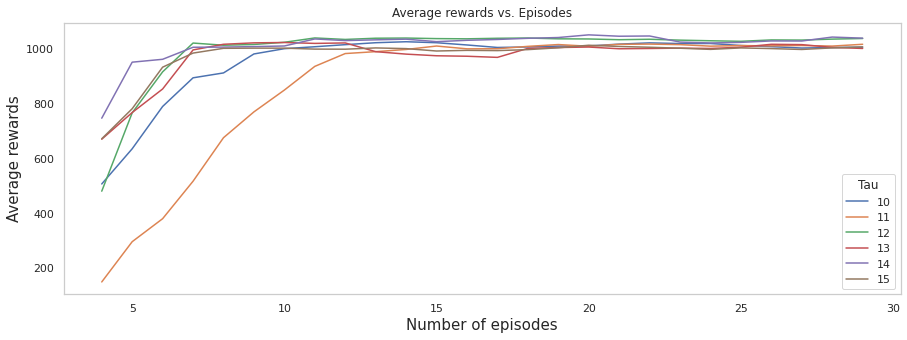

In [ ]:
myGridWorld.plot_graph(df_rewards.iloc[:30, 4:], "Average rewards vs. Episodes", "Number of episodes", "Average rewards", "Tau")

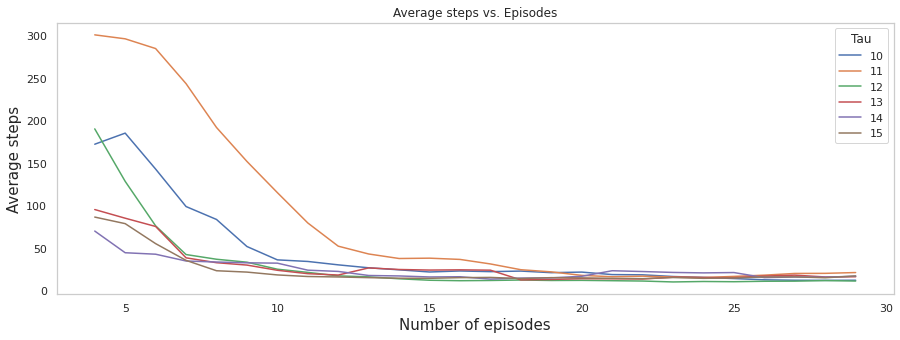

In [ ]:
myGridWorld.plot_graph(df_steps.iloc[:30, 4:], "Average steps vs. Episodes", "Number of episodes", "Average steps", "Tau")

In [ ]:
df_steps.iloc[:20, 2:].describe()

,8,9,10,11,12,13,14,15
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,304.562500,226.366667,62.200000,121.741667,41.145833,35.362500,27.770833,28.316667
std,125.767395,93.610085,57.104780,107.015360,50.381815,25.802761,15.251005,23.718678
min,183.533333,116.600000,20.866667,21.800000,11.400000,12.333333,13.266667,13.933333
25%,185.766667,180.933333,22.833333,37.266667,12.133333,22.666667,16.000000,15.000000
50%,258.800000,188.733333,32.066667,65.733333,19.133333,24.400000,23.066667,16.066667
75%,444.150000,248.600000,87.333333,204.766667,38.050000,34.033333,33.700000,26.183333
max,488.333333,459.266667,185.200000,300.933333,190.200000,95.200000,69.866667,86.333333


In [ ]:
df_ts

,6,7,8,9,10,11,12,13,14,15
0,585.0,580.0,587.666667,592.333333,599.333333,597.333333,599.0,600.0,600.0,600.0


#Using Bayesian Optimization for finding optimal parameters

In [ ]:
import numpy as np 
import statistics
import time 
from bayes_opt import BayesianOptimization

## for epsilon-greedy

In [276]:
def black_box_function(alpha, gamma, decay_rate):
    max_steps = MAX_STEPS
    num_eps = NUM_EPISODES
    policy = 'eps_greedy'
    myGridWorld = grid_world(False)
    rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps,
                                                                                   max_steps,
                                                                                   alpha,
                                                                                   gamma, policy, 
                                                                                   {'decay_rate' : decay_rate}) 
    
    
    return statistics.mean(rewards_per_episode)
    

pbounds = {'alpha': (0, 1), 'gamma': (0, 1) ,'decay_rate': (0.995, 0.9999) }

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(n_iter=100, init_points=5)
#print(optimizer.max)


|   iter    |  target   |   alpha   | decay_... |   gamma   |
-------------------------------------------------------------
Grid world initialized!
eps_greedy
time elapsed for 600 episodes : 7.8522186279296875 s
Path:  [1, 7, 5, 11, 5, 11, 17, 11, 17, 11, 17, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 10, 4, 3, 9, 3, 4, 3, 9, 3, 2, 8, 7, 5, 11, 5, 11, 17, 16, 10, 16, 10, 16, 10, 16, 10, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 17, 16, 10, 16, 10, 16, 10, 11, 5, 11, 5, 11, 10, 16, 15, 16, 10, 16, 10, 16, 10, 16, 10, 16, 15, 16, 10, 16, 15, 16, 10, 16, 10, 11, 17, 16, 10, 16, 10, 16, 10, 16, 17, 16, 10, 16, 10, 16, 10, 11, 17, 16, 10, 16, 10, 16, 15, 14, 13, 14, 13, 14, 13, 7, 8, 14, 13, 14, 13, 19, 13, 7, 5, 11, 5, 11, 5, 11, 5, 11, 17, 16, 10, 4, 10, 16, 10, 16, 17, 16, 17, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 10, 16, 17, 16, 10, 16, 10, 4, 10, 16, 10, 16, 10, 16, 10, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 10, 16,

In [277]:
print(optimizer.max)

{'target': 933.82, 'params': {'alpha': 0.3051853555871717, 'decay_rate': 0.995, 'gamma': 0.5386391260607708}}


## for softmax

In [280]:
def black_box_function(alpha, gamma, tau):
    max_steps = MAX_STEPS
    num_eps = NUM_EPISODES
    policy = 'softmax'
    myGridWorld = grid_world(False)
    rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps,
                                                                                   max_steps,
                                                                                   alpha,
                                                                                   gamma, policy, 
                                                                                   {'tau' : tau}) 
    
    
    return statistics.mean(rewards_per_episode)
    

pbounds = {'alpha': (0, 1), 'gamma': (0, 1) ,'tau': (6,14) }

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(n_iter=100, init_points=5)



|   iter    |  target   |   alpha   |   gamma   |    tau    |
-------------------------------------------------------------
Grid world initialized!
softmax
time elapsed for 600 episodes : 14.484351873397827 s
Path:  [1, 7, 13, 7, 5, 11, 10, 16, 15, 16, 22, 16, 15, 9, 10, 16, 10, 16, 22, 16, 22, 16, 10, 16, 10, 16, 15, 16, 10, 16, 10, 16, 15, 16, 10, 16, 15, 16, 15, 16, 22, 16, 15, 16, 15, 16, 10, 16, 22, 16, 22, 16, 10, 16, 10, 16, 22, 16, 10, 16, 22, 16, 15, 16, 10, 16, 22, 16, 22, 16, 15, 16, 10, 16, 15, 16, 22, 16, 15, 16, 15, 16, 10, 16, 10, 16, 15, 16, 15, 16, 10, 16, 15, 16, 10, 16, 22, 16, 22, 16, 10, 16, 22, 16, 15, 16, 15, 16, 15, 16, 15, 16, 10, 16, 22, 16, 15, 14, 13, 14, 13, 14, 13, 7, 5, 11, 10, 16, 15, 16, 10, 16, 15, 14, 13, 12, 13, 19, 13, 19, 13, 19, 13, 7, 13, 7, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 5, 11, 10, 16, 10, 16, 22, 16, 10, 16, 22, 16, 15, 16, 15, 16, 15, 16, 15, 16, 10, 16, 10, 16, 10, 16, 15, 16, 10, 16, 15, 16, 10, 16, 15, 16, 22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


time elapsed for 600 episodes : 16.62084674835205 s
Path:  [6, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


time elapsed for 600 episodes : 17.283214569091797 s
Path:  [6, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in true_divide


time elapsed for 600 episodes : 17.158812046051025 s
Path:  [6, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 30, 24, 

In [281]:
print(optimizer.max)

{'target': 1047.6916666666666, 'params': {'alpha': 0.8392039765327883, 'gamma': 0.41851047870519065, 'tau': 8.36871533899185}}


## Evaluate policies

In [299]:
myGridWorld  = grid_world(False)

Grid world initialized!


In [300]:
#{'target': 933.82, 'params': {'alpha': 0.3051853555871717, 'decay_rate': 0.995, 'gamma': 0.5386391260607708}}
alpha = 0.30518
gamma = 0.5386
decay_rate = 0.995 
policy= 'eps_greedy_decay'

max_steps = MAX_STEPS

num_eps = NUM_EPISODES + 100 

df_rewards = pd.DataFrame()
df_steps = pd.DataFrame()
df_ts = pd.DataFrame()


rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,  {'decay_rate': decay_rate})

df_rewards[policy] = rewards_per_episode 
df_steps[policy] = steps_per_episode
df_ts[policy] = found_flag




eps_greedy_decay
time elapsed for 700 episodes : 0.7973723411560059 s
Path:  [6, 7, 5, 11, 10, 16, 22, 23, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, -1.0, 20.0, -1.0, -1.0, -1.0, 991.0]
Total rewards: 1027.0 , Total path length: 10


In [307]:
#{'target': 1047.6916666666666, 'params': {'alpha': 0.8392039765327883, 'gamma': 0.41851047870519065, 'tau': 8.36871533899185}}

alpha = 0.8392
gamma = 0.4185
tau = 8.369
policy= 'softmax'

max_steps = MAX_STEPS

num_eps = NUM_EPISODES + 100 


rewards_per_episode, steps_per_episode, found_flag, Q = myGridWorld.run_q_learning(num_eps, max_steps, alpha, gamma, policy,  {'tau': tau})

df_rewards[policy] = rewards_per_episode 
df_steps[policy] = steps_per_episode
df_ts[policy] = found_flag


softmax
time elapsed for 700 episodes : 0.8554832935333252 s
Path:  [1, 7, 13, 7, 13, 7, 5, 11, 5, 11, 10, 16, 22, 23, 29, 35]
Rewards:  [-1.0, -1.0, 23.0, -1.0, 21.0, -1.0, 19.0, -1.0, 17.0, -1.0, -1.0, 14.0, -1.0, -1.0, -1.0, 985.0]
Total rewards: 1069.0 , Total path length: 16


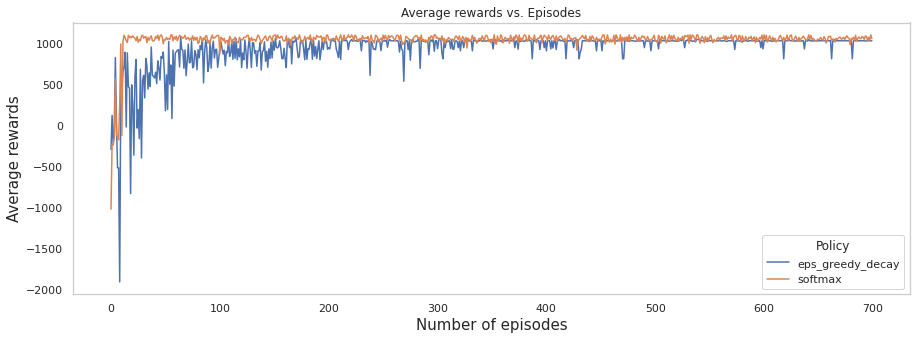

In [305]:
myGridWorld.plot_graph(df_rewards.iloc[:, :], "Average rewards vs. Episodes", "Number of episodes", "Average rewards", "Policy")

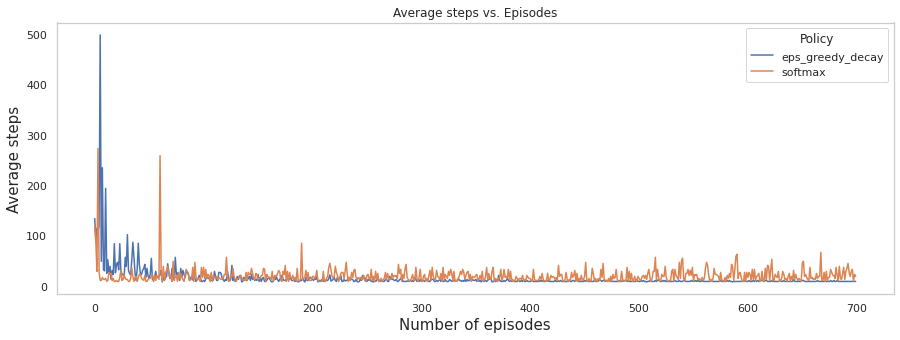

In [295]:
myGridWorld.plot_graph(df_steps.iloc[:,:], "Average steps vs. Episodes", "Number of episodes", "Average steps", "Policy")

In [296]:
df_rewards.iloc[:-100, :].describe()

,eps_greedy_decay,softmax
count,600.000000,600.000000
mean,904.240000,952.160000
std,435.694643,54.790307
min,-6646.000000,67.000000
25%,915.500000,928.000000
50%,1023.000000,958.000000
75%,1027.000000,980.000000
max,1059.000000,1000.000000


In [297]:
df_steps.iloc[:-100, :].describe()

,eps_greedy_decay,softmax
count,600.000000,600.000000
mean,16.241667,20.111667
std,26.689020,18.018332
min,8.000000,9.000000
25%,9.000000,11.000000
50%,11.000000,17.000000
75%,14.000000,25.000000
max,499.000000,273.000000
